GRAPH DERIVED FEATURES
-

Construct graphs for fixed time windows and calculate node centralities for each airport:
-

In [0]:
# Data import
df_flights = spark.read.format("parquet").option("header","true").load("dbfs:/mnt/mids-w261/OTPW_60M_Backup/")

# Imports and environment setup
from pyspark.sql import functions as F, DataFrame
from pyspark.sql.functions import (
    to_date, year, dayofyear,
    trunc, add_months, datediff,
    floor, col, row_number, trim,
    min as Fmin
)
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql import Row
from graphframes import GraphFrame
import networkx as nx

data_BASE_DIR = "dbfs:/mnt/mids-w261/"
one_year_data_path = "dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/"

def calculate_graph_features(spark_df, slice_idx):
  """
  Function to calculate graph features based on an input dataframe.
  Graph is built based on the number of flights between two airport codes and is directional.
  Currently calculates the following for each node:


  Args:
    spark_df (Spark DataFrame) - dataframe with flight data
    slice_idx (int) - index of the slice of the dataframe, added to the output for later joining

  Returns:
    centrality_df (Spark DataFrame) - dataframe with graph features within input df
  """

  # Load dataframe
  df_flights = spark_df

  # Get directional flight counts for graph weights
  pair_counts_df = (
      df_flights.groupBy("ORIGIN", "DEST")    
        .agg(F.count("*").alias("flights"))
  )

  # Invert counts for weights on each edge
  edges_df = (
      pair_counts_df
        .withColumnRenamed("ORIGIN", "src")
        .withColumnRenamed("DEST",   "dst")
        .withColumn("weight", 1.0 / F.col("flights").cast("double"))
        .select("src", "dst", "weight")
  )

  # Vertices from airport codes
  vertices_df = (
      edges_df
        .select(F.col("src").alias("id"))
        .union(edges_df.select(F.col("dst").alias("id")))
        .distinct()
  )

  # Collect edges into driver memory
  # edges_df must have columns: src, dst, weight
  edge_rows = edges_df.select("src", "dst", "weight").collect()
  edge_tuples = [(r["src"], r["dst"], r["weight"]) for r in edge_rows]

  #  Build a directed NetworkX graph with weights
  G = nx.DiGraph()
  G.add_weighted_edges_from(edge_tuples)  # (u, v, weight)

  #-----------Calculate relevant centralities------------
  # Calculate betweenness centrality
  bet = nx.betweenness_centrality(G, weight="weight", normalized=True)

  # Calculate degree centrality (normalized by default)
  deg = nx.degree_centrality(G)

  # Calculate closeness centrality
  clo = nx.closeness_centrality(G, distance="weight")  # use 'distance' instead of 'weight'

  # --- Combine all results into a list of Rows ---
  all_nodes = set(bet) | set(deg) | set(clo)

  rows = [
      Row(
          SLICE_IDX_GLOBAL=slice_idx,
          node=str(n),
          betweenness=bet.get(n, 0.0),
          degree=deg.get(n, 0.0),
          closeness=clo.get(n, 0.0)
      )
      for n in all_nodes
  ]

  # --- Define schema ---
  schema = StructType([
      StructField("SLICE_IDX_GLOBAL", IntegerType(), False),
      StructField("NODE", StringType(), False),
      StructField("BETWEENNESS", DoubleType(), False),
      StructField("DEGREE", DoubleType(), False),
      StructField("CLOSENESS", DoubleType(), False)
  ])

  # --- Create Spark DataFrame and return ---
  centrality_df = spark.createDataFrame(rows, schema=schema)
  return centrality_df


# Run function and show resulting df
# centralities = calculate_graph_features(df_flights, 1)
# display(centralities)

In [0]:
def slice_and_add_graph_features(spark_df, desired_slice_count=4):
    """
    Function to define number of slices per year, partition flights accordingly,
    and then calculate graph features for each slice. Features are joined to the previous slice
    from which they are calculated to avoid data leakage.

    Args:
    spark_df (Spark DataFrame) - dataframe with flights data
    desired_slice_count (int) - number of slices per year

    Returns:
    Spark DataFrame - original df with centrality measures added according to specified slices

    """
    # Number of slices per year (e.g. 4 for quarters)
    slice_count = desired_slice_count

    # 1) Parse, extract year, doy, and days_in_year; compute per-year slice_idx
    df_sliced = (
        spark_df
        .withColumn("dt", to_date("FL_DATE"))
        .withColumn("year", year("dt"))
        .withColumn("doy", dayofyear("dt"))
        .withColumn("start_of_year", trunc("dt", "year"))
        .withColumn("start_next_year", add_months(col("start_of_year"), 12))
        .withColumn("days_in_year", datediff(col("start_next_year"), col("start_of_year")))
        .withColumn(
            "slice_idx_year",
            floor((col("doy") - 1) * slice_count / col("days_in_year")) + 1
        )
        .drop("dt", "doy", "start_of_year", "start_next_year", "days_in_year")
    )

    # 2) Build a small DataFrame of distinct years with a zero-based rank
    year_rank_df = (
        df_sliced
        .select("year")
        .distinct()
        .orderBy("year")
        .withColumn("year_rank", row_number().over(Window.orderBy("year")) - 1)
    )

    # Join back to get the year_rank on every row
    df_ranked = df_sliced.join(year_rank_df, on="year", how="left")

    # Compute the global slice index
    df_global_sliced = df_ranked.withColumn(
        "SLICE_IDX_GLOBAL",
        col("year_rank") * slice_count + col("slice_idx_year")
    ).drop("year_rank", "year", "slice_idx_year")
    
    # Slice idx normalization (in case we start part of the way through a year)
    # Find the minimum global slice index across the whole DF
    min_idx_df = df_global_sliced.agg(
        Fmin("SLICE_IDX_GLOBAL").alias("min_idx")
    )

    # Subtract (min_idx - 1) from every slice to make the lowest = 1
    df_norm = (
        df_global_sliced
        .crossJoin(min_idx_df)
        .withColumn(
            "SLICE_IDX_GLOBAL",
            col("SLICE_IDX_GLOBAL") - (col("min_idx") - 1)
        )
        .drop("min_idx")
    )

    # At this point each flight is assigned to a window in time, whose size is user specified

    # Collect distinct slice indices for iteration
    slice_idx_list = (
    df_norm
      .select("SLICE_IDX_GLOBAL")
      .distinct()
      .orderBy("SLICE_IDX_GLOBAL")
      .rdd
      .map(lambda r: r["SLICE_IDX_GLOBAL"])
      .collect()
    )

    # Set new alias to df for easy reading, add previous slice idx for easier join
    df_joining = df_norm.withColumn("SLICE_IDX_PREV", col("SLICE_IDX_GLOBAL") - 1)

    # Set up centrality master df to collect centralities for each slice
    centrality_master: DataFrame = None

    # Iterate through each slice index to generate centralities on each slice
    for slice_idx in slice_idx_list:
        df_slice = df_norm.filter(col("SLICE_IDX_GLOBAL") == slice_idx)

        # Use previous function to generate graph features
        slice_centrality = calculate_graph_features(df_slice, slice_idx)

        if centrality_master == None:
            centrality_master = slice_centrality
        else:
            centrality_master = centrality_master.unionByName(slice_centrality)

        print(f"Iteration {slice_idx} completed!")


    # Specify names of calculated metrics for columns
    metrics = ["BETWEENNESS","DEGREE","CLOSENESS"]

    # Prepare the ORIGIN lookup
    src_lookup = (
        centrality_master
        .select(
            col("NODE").alias("ORIGIN_NODE"),
            col("SLICE_IDX_GLOBAL").alias("ORIGIN_SLICE"),
            *[
            col(m).alias(f"ORIGIN_{m.upper()}")
            for m in metrics
            ]
        )
    )

    # Join ORIGIN centralities in, offset by 1 to previous slice
    df_joining = df_joining.join(
        src_lookup,
        on=(
        (col("ORIGIN") == col("ORIGIN_NODE")) &
        (col("SLICE_IDX_PREV") == col("ORIGIN_SLICE"))
        ),
        how="left"
    ).drop("ORIGIN_NODE","ORIGIN_SLICE")

    # Prepare the DEST lookup
    dst_lookup = (
        centrality_master
        .select(
            col("NODE").alias("DEST_NODE"),
            col("SLICE_IDX_GLOBAL").alias("DEST_SLICE"),
            *[
            col(m).alias(f"DEST_{m.upper()}")
            for m in metrics
            ]
        )
    )

    # Join DEST centralities in, offset by 1 to previous slice, rename df to reflect complete state
    df_final = df_joining.join(
        dst_lookup,
        on=(
        (col("DEST") == col("DEST_NODE")) &
        (col("SLICE_IDX_PREV") == col("DEST_SLICE"))
        ),
        how="left"
    ).drop("DEST_NODE","DEST_SLICE", "SLICE_IDX_PREV", "SLICE_IDX_GLOBAL")  # also drop all slice indices since features have been calculated/joined

    # Show final df
    return df_final
    

# Run function and display output
output = slice_and_add_graph_features(df_flights.dropDuplicates(), desired_slice_count=12)
display(output)

Iteration 1 completed!
Iteration 2 completed!
Iteration 3 completed!
Iteration 4 completed!
Iteration 5 completed!
Iteration 6 completed!
Iteration 7 completed!
Iteration 8 completed!
Iteration 9 completed!
Iteration 10 completed!
Iteration 11 completed!
Iteration 12 completed!
Iteration 13 completed!
Iteration 14 completed!
Iteration 15 completed!
Iteration 16 completed!
Iteration 17 completed!
Iteration 18 completed!
Iteration 19 completed!
Iteration 20 completed!
Iteration 21 completed!
Iteration 22 completed!
Iteration 23 completed!
Iteration 24 completed!
Iteration 25 completed!
Iteration 26 completed!
Iteration 27 completed!
Iteration 28 completed!
Iteration 29 completed!
Iteration 30 completed!
Iteration 31 completed!
Iteration 32 completed!
Iteration 33 completed!
Iteration 34 completed!
Iteration 35 completed!
Iteration 36 completed!
Iteration 37 completed!
Iteration 38 completed!
Iteration 39 completed!
Iteration 40 completed!
Iteration 41 completed!
Iteration 42 completed!
I

QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed Sunrise Sunset DailyAverageDewPointTemperature DailyAverageDryBulbTemperature DailyAverageRelativeHumidity DailyAverageSeaLevelPressure DailyAverageStationPressure DailyAverageWetBulbTemperature DailyAverageWindSpeed DailyCoolingDegreeDays DailyDepartureFromNormalAverageTemperature DailyHeatingDegreeDays DailyMaximumDryBulbTemperature DailyMinimumDryBulbTemperature DailyPeakWindDirection DailyPeakWindSpeed DailyPrecipitation DailySnowDepth DailySnowfall DailySustainedWindDirection DailySustainedWindSpeed DailyWeather MonthlyAverageRH MonthlyDaysWithGT001Precip MonthlyDaysWithGT010Precip MonthlyDaysWithGT32Temp MonthlyDaysWithGT90Temp MonthlyDaysWithLT0Temp MonthlyDaysWithLT32Temp MonthlyDepartureFromNormalAverageTemperature MonthlyDepartureFromNormalCoolingDegreeDays MonthlyDepartureFromNormalHeatingDegreeDays MonthlyDepartureFromNormalMaximumTemperature MonthlyDepartureFromNormalMinimumTemperature MonthlyDepartureFromNormalPrecipitation MonthlyDewpointTemperature MonthlyGreatestPrecip MonthlyGreatestPrecipDate MonthlyGreatestSnowDepth MonthlyGreatestSnowDepthDate MonthlyGreatestSnowfall MonthlyGreatestSnowfallDate MonthlyMaxSeaLevelPressureValue MonthlyMaxSeaLevelPressureValueDate MonthlyMaxSeaLevelPressureValueTime MonthlyMaximumTemperature MonthlyMeanTemperature MonthlyMinSeaLevelPressureValue MonthlyMinSeaLevelPressureValueDate MonthlyMinSeaLevelPressureValueTime MonthlyMinimumTemperature MonthlySeaLevelPressure MonthlyStationPressure MonthlyTotalLiquidPrecipitation MonthlyTotalSnowfall MonthlyWetBulb AWND CDSD CLDD DSNW HDSD HTDD NormalsCoolingDegreeDay NormalsHeatingDegreeDay ShortDurationEndDate005 ShortDurationEndDate010 ShortDurationEndDate015 ShortDurationEndDate020 ShortDurationEndDate030 ShortDurationEndDate045 ShortDurationEndDate060 ShortDurationEndDate080 ShortDurationEndDate100 ShortDurationEndDate120 ShortDurationEndDate150 ShortDurationEndDate180 ShortDurationPrecipitationValue005 ShortDurationPrecipitationValue010 ShortDurationPrecipitationValue015 ShortDurationPrecipitationValue020 ShortDurationPrecipitationValue030 ShortDurationPrecipitationValue045 ShortDurationPrecipitationValue060 ShortDurationPrecipitationValue080 ShortDurationPrecipitationValue100 ShortDurationPrecipitationValue120 ShortDurationPre

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd

# 1) List of departing‑airport centrality columns
metrics = [
    "ORIGIN_BETWEENNESS",
    "ORIGIN_DEGREE",
    "ORIGIN_CLOSENESS"
]

# 2) Select & drop any rows with nulls in those columns
df_metrics = (
    output
      .select(*metrics)
      .na.drop()
)

# 3) Assemble into a single vector column
assembler = VectorAssembler(inputCols=metrics, outputCol="features")
df_vector = assembler.transform(df_metrics).select("features")

# 4) Use Spark’s built-in Correlation to compute the Pearson matrix
matrix_row = Correlation.corr(df_vector, "features", "pearson").head()
corr_matrix = matrix_row[0].toArray()   # this is a numpy array

# 5) Turn it into a nicely labeled pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, index=metrics, columns=metrics)

# 6) Show it
print("Pearson correlation matrix of departing‑airport centralities:")
print(corr_df)

Pearson correlation matrix of departing‑airport centralities:
                    ORIGIN_BETWEENNESS  ORIGIN_DEGREE  ORIGIN_CLOSENESS
ORIGIN_BETWEENNESS            1.000000       0.797281          0.313162
ORIGIN_DEGREE                 0.797281       1.000000          0.450599
ORIGIN_CLOSENESS              0.313162       0.450599          1.000000


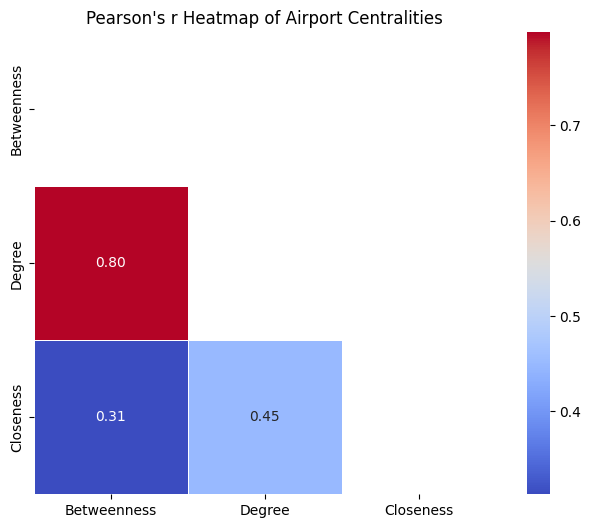

In [0]:
# 1) define a mapping from old name to new name
rename_map = {
    "ORIGIN_BETWEENNESS": "Betweenness",
    "ORIGIN_DEGREE":      "Degree",
    "ORIGIN_CLOSENESS":   "Closeness",
    "ORIGIN_PAGERANK":    "PageRank"
}

# 2) apply it to both index and columns of your corr_df
corr_df_pretty = corr_df.rename(index=rename_map, columns=rename_map)

# 3) plot exactly as before, just point at corr_df_pretty
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

mask = np.triu(np.ones_like(corr_df_pretty, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df_pretty,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    mask=mask,
    cbar=True,
    square=True,
    linewidths=0.5,
    xticklabels=True,
    yticklabels=True
)
plt.title("Pearson's r Heatmap of Airport Centralities")
plt.show()
